# Diversity Aware Book Recommender
> A tutorial on building an amazon-like book recommender and keeping diversity as an important factor

In [ ]:
# Import libraries
import numpy as np 
import pandas as pd 
import matplotlib
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Displays all rows without truncating
pd.set_option('display.max_rows', None)

# Display all columns with/without truncating (use "set" or "reset")
pd.reset_option('display.max_colwidth')

In [ ]:
# Load book data from csv
books = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads_v2/books.csv", encoding="ISO-8859-1")
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [ ]:
books.sample(20)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
6032,6033,20893314,20893314,40236328,45,159448600X,9.781594e+12,Marlon James,2014.0,A Brief History of Seven Killings,A Brief History of Seven Killings,eng,3.86,13578,17119,2753,768,1238,3250,6222,5641,https://images.gr-assets.com/books/1399045083m...,https://images.gr-assets.com/books/1399045083s...
4309,4310,68526,68526,891853,69,60888628,9.780061e+12,Bernard Cornwell,2006.0,The Lords of the North,"Lords of the North (The Saxon Stories, #3)",en-US,4.32,20296,24501,811,43,222,2766,10393,11077,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7584,7585,551536,551536,538777,17,439845823,9.780440e+12,Chris d'Lacey,2005.0,Fire Star,"Fire Star (The Last Dragon Chronicles, #3)",eng,3.91,13595,14228,442,388,1018,3320,4206,5296,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8297,8298,33906,33906,2420507,19,316014532,9.780316e+12,Sara Zarr,2007.0,Story of a Girl,Story of a Girl,en-US,3.67,14282,15064,1608,391,1430,4626,4886,3731,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9438,9439,35539,35539,1654509,17,316013315,9.780316e+12,Bob Spitz,2005.0,The Beatles: The Biography,The Beatles: The Biography,en-US,4.13,8120,8464,390,205,314,1270,3020,3655,https://images.gr-assets.com/books/1327951066m...,https://images.gr-assets.com/books/1327951066s...
5580,5581,48037,48037,47015,397,809510839,9.780810e+12,J. Sheridan Le Fanu,1872.0,Carmilla,Carmilla,eng,3.83,21582,24992,1668,338,1449,7088,9344,6773,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6091,6092,920143,920143,596404,8,823404706,9.780823e+12,"Trina Schart Hyman, Johann Grimm, Wilhelm Grimm",1983.0,RotkÃ¤ppchen,Little Red Riding Hood,eng,4.11,19224,19453,507,150,792,4489,5308,8714,https://images.gr-assets.com/books/1314485414m...,https://images.gr-assets.com/books/1314485414s...
8413,8414,17262236,17262236,23859036,28,1423183096,9.781423e+12,Elizabeth Wein,2013.0,Rose Under Fire,"Rose Under Fire (Code Name Verity, #2)",eng,4.13,13526,15064,2573,430,523,2029,5764,6318,https://images.gr-assets.com/books/1368219053m...,https://images.gr-assets.com/books/1368219053s...
5367,5368,25776122,25776122,45625060,4,812993101,9.780813e+12,Helen Simonson,2016.0,The Summer Before the War,The Summer Before the War,eng,3.79,17350,22240,3613,408,1439,5778,9356,5259,https://images.gr-assets.com/books/1443294379m...,https://images.gr-assets.com/books/1443294379s...
8445,8446,13063,13063,25591382,32,446695645,9.780447e+12,Carl Hiaasen,2002.0,NaN,Basket Case,NaN,3.81,11909,13127,763,76,559,3936,5824,2732,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


There are 10,000 books in this dataset and we want “book tags” as a key feature because it has rich data about the books to help us with recommendations. That data lives in different datasets so we have to data wrangle and piece the data puzzle together.

In [ ]:
# Load tags book_tags data from csv
book_tags = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads_v2/book_tags.csv", encoding="ISO-8859-1")
tags = pd.read_csv("https://raw.githubusercontent.com/sparsh-ai/reco-data/master/goodreads_v2/tags.csv", encoding="ISO-8859-1")
# Merge book_tags and tags 
tags_join = pd.merge(book_tags, tags, left_on='tag_id', right_on='tag_id', how='inner')
# Merge tags_join and books
books_with_tags = pd.merge(books, tags_join, left_on='book_id', right_on='goodreads_book_id', how='inner')
# Store tags into the same book id row
temp_df = books_with_tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()
temp_df.head(5)
# Merge tag_names back into books
books = pd.merge(books, temp_df, left_on='book_id', right_on='book_id', how='inner')
books.sample(20)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_name
6410,6411,21328,21328,1425228,10,1401205003,9.781401e+12,"Bill Willingham, Mark Buckingham, David Hahn, ...",2006.0,"Fables, Volume 6: Homelands","Fables, Vol. 6: Homelands",eng,4.30,18893,19219,585,123,330,2310,7260,9196,https://images.gr-assets.com/books/1327962707m...,https://images.gr-assets.com/books/1327962707s...,to-read fantasy favorites currently-reading fi...
4457,4458,536982,536982,524423,32,1597372552,9.781597e+12,D.J. MacHale,2003.0,The Never War,"The Never War (Pendragon, #3)",eng,4.12,24219,25245,474,266,914,4836,8727,10502,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read fantasy favorites currently-reading yo...
9207,9208,22040598,22040598,41363353,18,1596435739,9.781596e+12,Scott McCloud,2015.0,The Sculptor,The Sculptor,eng,4.00,10038,10902,1789,327,655,1981,3614,4325,https://images.gr-assets.com/books/1418629570m...,https://images.gr-assets.com/books/1418629570s...,to-read fantasy favorites currently-reading yo...
6392,6393,427920,427920,2461275,52,1558744630,9.781559e+12,"Jack Canfield, Mark Victor Hansen, Kimberly Ki...",1997.0,Chicken Soup for the Teenage Soul (Chicken Sou...,Chicken Soup for the Teenage Soul: 101 Stories...,eng,3.91,14722,16097,716,324,1049,4013,5058,5653,https://images.gr-assets.com/books/1331052651m...,https://images.gr-assets.com/books/1331052651s...,to-read favorites currently-reading young-adul...
4108,4109,18301124,27237358,25789248,39,NaN,9.781302e+12,Amy Harmon,2013.0,Making Faces,Making Faces,eng,4.36,25941,42130,6337,607,1256,4663,11327,24277,https://images.gr-assets.com/books/1378983590m...,https://images.gr-assets.com/books/1378983590s...,to-read favorites currently-reading young-adul...
1592,1593,13812,13812,15983,58,553564943,9.780554e+12,Raymond E. Feist,1982.0,Magician,"Magician: Apprentice (The Riftwar Saga, #1)",en-US,4.17,62432,64948,1231,806,2358,10465,22606,28713,https://images.gr-assets.com/books/1408317983m...,https://images.gr-assets.com/books/1408317983s...,to-read fantasy favorites currently-reading yo...
7854,7855,351559,351559,1459650,87,61043559,9.780061e+12,Dorothy L. Sayers,1933.0,Murder Must Advertise,"Murder Must Advertise (Lord Peter Wimsey, #10)",eng,4.21,14672,15762,654,102,353,2572,5771,6964,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read favorites currently-reading fiction bo...
732,733,77142,77142,1677615,97,067976402X,9.780680e+12,David Guterson,1994.0,Snow Falling on Cedars,Snow Falling on Cedars,eng,3.80,131945,136212,3881,2507,9023,35994,54408,34280,https://images.gr-assets.com/books/1479863528m...,https://images.gr-assets.com/books/1479863528s...,to-read favorites currently-reading fiction bo...
7884,7885,28802599,28802599,24952557,10,NaN,NaN,"Paul Pen, Simon Bruni",2013.0,NaN,The Light of the Fireflies,en-US,3.76,13815,15048,1743,447,1247,3809,5523,4022,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read favorites currently-reading young-adul...
6385,6386,7438179,7438179,9438856,33,345496574,9.780345e+12,Peter F. Hamilton,2009.0,The Evolutionary Void,The Evolutionary Void,eng,4.25,13440,15609,471,89,310,2114,6120,6976,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read fantasy favorites currently-reading fi...


We now have book tags all in one dataset.

We have 10,000 books in the dataset each with 100 book tags. What do these book tags contain?

In [ ]:
# Explore book tags
books['tag_name'][0]

'to-read fantasy favorites currently-reading young-adult fiction books-i-own owned ya series favourites re-read adventure sci-fi-fantasy all-time-favorites default my-books reread i-own audiobook 5-stars favorite-books novels fantasy-sci-fi favorite audiobooks read-more-than-once my-library ya-fantasy teen english books ya-fiction my-favorites own-it library audio young-adult-fiction novel scifi-fantasy faves favorite-series shelfari-favorites kindle romance favourite to-buy read-in-2014 ebook contemporary 5-star coming-of-age favourite-books favs action read-in-2013 read-in-2011 finished ya-books borrowed sci-fi ya-lit loved love thriller science-fiction finished-series action-adventure scifi sf book-club speculative-fiction ebooks e-book read-in-2012 read-in-2010 survival future drama reviewed suspense dystopia dystopian post-apocalyptic read-2012 dystopias dystopian-fiction distopia distopian read-2011 teen-fiction 2012-reads futuristic ya-dystopian trilogy completed-series love-tri

In [ ]:
books['tag_name'][1]

'to-read fantasy favorites currently-reading young-adult fiction harry-potter books-i-own owned owned ya series favourites magic childrens owned-books re-read adventure children j-k-rowling children-s sci-fi-fantasy childhood all-time-favorites default my-books classics reread i-own audiobook 5-stars children-s-books favorite-books kids novels fantasy-sci-fi favorite middle-grade audiobooks paranormal read-more-than-once my-library ya-fantasy teen witches english urban-fantasy british jk-rowling books read-in-2016 supernatural re-reads mystery ya-fiction harry-potter-series my-favorites own-it childrens-books library audio young-adult-fiction novel scifi-fantasy wizards faves favorite-series read-in-2015 juvenile shelfari-favorites kindle youth favourite to-buy read-in-2014 to-re-read all-time-favourites childhood-favorites kids-books ebook rereads contemporary read-in-english science-fiction-fantasy read-in-2017 england children-s-literature favourite-books on-my-shelf my-bookshelf ch

We want to transform these texts into numerical values so we have data that the machine learning algorithm understands. TfidfVectorizer turns text into feature vectors.

In [ ]:
# Transform text to feature vectors
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=50, stop_words='english')
tfidf_matrix = tf.fit_transform(books['tag_name'])
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

TF-IDF (Term Frequency — Inverse Document Frequency) calculates how important words are in relation to the whole document. TF summarizes how often a given word appears within a document. IDF downscales words that appear frequently across documents. This allows TF-IDF to define the importance of words within a document based on the relationship and weighting factor.

Now we build the recommender. We can use cosine similarity to calculate the numeric values that denote similarities between books.

In [ ]:
tfidf_matrix

<10000x4156 sparse matrix of type '<class 'numpy.float64'>'
	with 1645829 stored elements in Compressed Sparse Row format>

In [ ]:
# Use numeric values to find similarities
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.36212089, 0.44541704, ..., 0.13917794, 0.1348777 ,
        0.02627779],
       [0.36212089, 1.        , 0.34429371, ..., 0.14158388, 0.11790885,
        0.03529777],
       [0.44541704, 0.34429371, 1.        , ..., 0.09165124, 0.07197058,
        0.0228239 ],
       ...,
       [0.13917794, 0.14158388, 0.09165124, ..., 1.        , 0.07749932,
        0.19530793],
       [0.1348777 , 0.11790885, 0.07197058, ..., 0.07749932, 1.        ,
        0.12073876],
       [0.02627779, 0.03529777, 0.0228239 , ..., 0.19530793, 0.12073876,
        1.        ]])

Cosine similarity measures the cosine of the angle between two vectors projected in a multi-dimensional space. The smaller the angle, the higher the cosine similarity. In other words, the closer these book tags are to each other, the more similar the book.


Next we write the machine learning algorithm.


In [ ]:
# Get book recommendations based on the cosine similarity score of book tags
# Build a 1-dimensional array with book titles
titles = books['title']
tag_name = books['tag_name']
indices = pd.Series(books.index, index=books['title'])
# Function that gets similarity scores
def tags_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # sim_scores = sim_scores[1:11] # How many results to display
    book_indices = [i[0] for i in sim_scores]
    title_df = pd.DataFrame({'title': titles.iloc[book_indices].tolist(),
                           'similarity': [i[1] for i in sim_scores],
                            'tag_name': tag_name.iloc[book_indices].tolist()}, 
                           index=book_indices)
    return title_df

This is the foundational code we need for a recommendation engine. This is the building block for Amazon’s $98 billion revenue-generating algorithm and others like it. Almost seems too simple. We can stop here or we can expand our code to show more data insights.

In [ ]:
# Function that gets book tags and stats
def recommend_stats(target_book_title):
    
    # Get recommended books
    rec_df = tags_recommendations(target_book_title)
    
    # Get tags of the target book
    rec_book_tags = books_with_tags[books_with_tags['title'] == target_book_title]['tag_name'].to_list()
    
    # Create dictionary of tag lists by book title
    book_tag_dict = {}
    for title in rec_df['title'].tolist():
        book_tag_dict[title] = books_with_tags[books_with_tags['title'] == title]['tag_name'].to_list()
    
    # Create dictionary of tag statistics by book title
    tags_stats = {}
    for book, tags in book_tag_dict.items():
        tags_stats[book] = {}
        tags_stats[book]['total_tags'] = len(tags)
        same_tags = set(rec_book_tags).intersection(set(tags)) # Get tags in recommended book that are also in target book
        tags_stats[book]['%_common_tags'] = (len(same_tags) / len(tags)) * 100
    
    # Convert dictionary to dataframe
    tags_stats_df = pd.DataFrame.from_dict(tags_stats, orient='index').reset_index().rename(columns={'index': 'title'})
    
    # Merge tag statistics dataframe to recommended books dataframe
    all_stats_df = pd.merge(rec_df, tags_stats_df, on='title')
    return all_stats_df

Now we input Lord of the Rings into the recommendation engine and see the results.

In [ ]:
# Find book recommendations
lor_recs = recommend_stats('The Fellowship of the Ring (The Lord of the Rings, #1)')
lor_recs

,title,similarity,tag_name,total_tags,%_common_tags
0,The Fellowship of the Ring (The Lord of the Ri...,1.000000,to-read fantasy favorites currently-reading yo...,100,100.000000
1,"The Return of the King (The Lord of the Rings,...",0.891312,to-read fantasy favorites currently-reading yo...,100,92.000000
2,"The Two Towers (The Lord of the Rings, #2)",0.862019,to-read fantasy favorites currently-reading yo...,100,90.000000
3,"The Lord of the Rings (The Lord of the Rings, ...",0.788876,to-read fantasy favorites currently-reading yo...,100,84.000000
4,The Silmarillion (Middle-Earth Universe),0.742551,to-read fantasy favorites currently-reading yo...,100,77.000000
5,The Hobbit,0.678304,to-read fantasy favorites currently-reading yo...,100,76.000000
6,The Children of HÃºrin,0.670856,to-read fantasy favorites currently-reading yo...,100,67.000000
7,Dragons of Autumn Twilight (Dragonlance: Chro...,0.658293,to-read fantasy favorites currently-reading yo...,100,65.000000
8,"Pawn of Prophecy (The Belgariad, #1)",0.644427,to-read fantasy favorites currently-reading yo...,100,61.000000
9,"Castle of Wizardry (The Belgariad, #4)",0.642979,to-read fantasy favorites currently-reading yo...,100,59.000000


We get a list of the top 10 most similar books to Lord of the Rings based on book tags. 

Since we are reverse engineering through the Elon Musk customer lens and wanting the recommender to output Zero to One, let’s find where this book is positioned in relation to Lord of the Rings.

In [ ]:
# Find Zero to One book
lor_recs[lor_recs.title == 'Zero to One: Notes on Startups, or How to Build the Future']

,title,similarity,tag_name,total_tags,%_common_tags
8870,"Zero to One: Notes on Startups, or How to Buil...",0.070141,to-read favorites currently-reading books-i-ow...,100,23.0


In relation to Lord of the Rings, Zero to One is rank 8,871 (because index starts from zero, index 0 means rank 1, e.g.) out of 10,000 books based on similarities. Pretty low. According to the algorithm, these two books are on opposite ends of the spectrum and not similar at all. This book is statistically in the lowest quartile which means neither you nor Elon would be recommended this diversity of thought.

In [ ]:
# Calculate statistical data
lor_recs.describe()

,similarity,total_tags,%_common_tags
count,10000.000000,10000.000000,10000.000000
mean,0.178780,100.791200,32.274768
std,0.123885,10.475045,8.876842
min,0.017716,56.000000,4.000000
25%,0.093142,100.000000,26.000000
50%,0.139815,100.000000,32.000000
75%,0.220862,100.000000,38.000000
max,1.000000,400.000000,100.000000


Using a boxplot, we can better visualize this positioning:


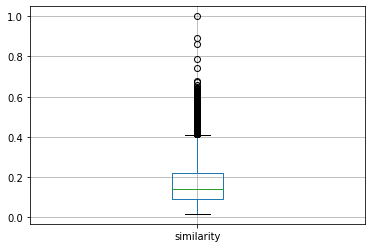

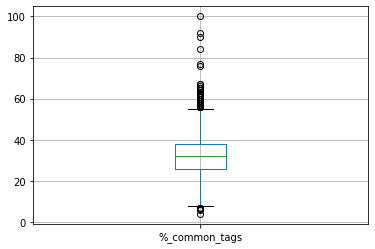

In [ ]:
# Boxplot of similarity score
import matplotlib.pyplot as plt
lor_recs.boxplot(column=['similarity'])
plt.show()
# Boxplot of percentage of common tags
lor_recs.boxplot(column=['%_common_tags'])
plt.show()

We can explore the data further and find the most common book tags using NLTK (Natural Language Toolkit). First, we clean up words such as removing hyphens, tokenize the words, and then remove all the stop words. After the text is clean, we can calculate the top 10 frequent words that appear in the Lord of the Rings book tags.


All frequencies, including STOPWORDS:
        Word  Frequency
0    fantasy         12
1    fiction          8
2       read          7
3      books          6
4         my          5
5  favorites          4
6        sci          4
7         fi          4
8         to          3
9      adult          3


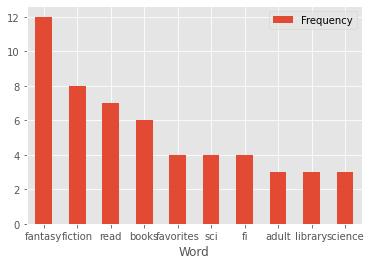

In [ ]:
# Store book tags into new dataframe
lor_tags = pd.DataFrame(books_with_tags[books_with_tags['title']=='The Fellowship of the Ring (The Lord of the Rings, #1)']['tag_name'])
# Find most frequent word used in book tags
top_N = 10
txt = lor_tags.tag_name.str.lower().str.replace(r'-', ' ').str.cat(sep=' ') # Remove hyphens
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies, including STOPWORDS:')
print('=' * 60)
lor_rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(lor_rslt)
print('=' * 60)
lor_rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
matplotlib.style.use('ggplot')
lor_rslt.plot.bar(rot=0)
plt.show()

Since we want diversity and variety, we can take the most frequent words “fantasy” and “fiction” and filter by unlike or different words in the context of book genres. These might be words like non-fiction, economics, or entrepreneurial.

In [ ]:
# Filter by unlike words
lor_recs_filter = lor_recs[(lor_recs['tag_name'].str.contains('non-fiction')) & (lor_recs['tag_name'].str.contains('economics')) & (lor_recs['tag_name'].str.contains('entrepreneurial'))]
lor_recs_filter

,title,similarity,tag_name,total_tags,%_common_tags
8870,"Zero to One: Notes on Startups, or How to Buil...",0.070141,to-read favorites currently-reading books-i-ow...,100,23.0
9118,The $100 Startup: Reinvent the Way You Make a ...,0.064657,to-read favorites currently-reading books-i-ow...,100,22.0
9271,The Dip: A Little Book That Teaches You When t...,0.061224,to-read favorites currently-reading books-i-ow...,100,23.0
9526,The Lean Startup: How Today's Entrepreneurs Us...,0.054029,to-read favorites currently-reading books-i-ow...,100,24.0
9830,"The Art of the Start: The Time-Tested, Battle-...",0.040467,to-read favorites currently-reading books-i-ow...,100,22.0
9881,The E-Myth Revisited: Why Most Small Businesse...,0.037058,to-read favorites currently-reading books-i-ow...,100,22.0
9890,Business Model Generation,0.036355,to-read favorites currently-reading books-i-ow...,100,20.0


This narrows down the list and only include books that contain “non-fiction”, “economics”, or “entrepreneurial” in the book tags. To ensure our reader is recommended a good book, we merge ‘average_rating’ back into the dataset and sort the results by the highest average book rating.

In [ ]:
# Merge recommendations with ratings
lor_recs_filter_merge = pd.merge(books[['title', 'average_rating']], lor_recs_filter, left_on='title', right_on='title', how='inner')
# Sort by highest average rating
lor_recs_filter_merge = lor_recs_filter_merge.sort_values(by=['average_rating'], ascending=False)
lor_recs_filter_merge

,title,average_rating,similarity,tag_name,total_tags,%_common_tags
1,"Zero to One: Notes on Startups, or How to Buil...",4.17,0.070141,to-read favorites currently-reading books-i-ow...,100,23.0
4,Business Model Generation,4.16,0.036355,to-read favorites currently-reading books-i-ow...,100,20.0
0,The Lean Startup: How Today's Entrepreneurs Us...,4.04,0.054029,to-read favorites currently-reading books-i-ow...,100,24.0
2,The E-Myth Revisited: Why Most Small Businesse...,3.98,0.037058,to-read favorites currently-reading books-i-ow...,100,22.0
3,The $100 Startup: Reinvent the Way You Make a ...,3.85,0.064657,to-read favorites currently-reading books-i-ow...,100,22.0
6,The Dip: A Little Book That Teaches You When t...,3.83,0.061224,to-read favorites currently-reading books-i-ow...,100,23.0
5,"The Art of the Start: The Time-Tested, Battle-...",3.82,0.040467,to-read favorites currently-reading books-i-ow...,100,22.0


What appears at the top of the list — Zero to One. We engineered our way into recommending diversity. Here’s an alternative solution. Instead of recommendations based on book tags of the individual book, we can make recommendations based on categories. The rule: each recommendation can still have similarities to the original book, but it must be a unique category.

Instead of 5 books with similar book tags to Lord of the Rings, the result should be 5 books with similar book tags, but with a different category to Fantasy, such as Science Fiction. Subsequent results would follow the same logic. This would “diversify” the categories of books the user sees, while maintaining a chain of relevancy. It would display: Fantasy → Science Fiction → Technology → Entrepreneurship → Biographies.

This categorization becomes a sort within a sort to ensure a quality, relevant, and diverse read. This concept could more systematically connect books like Lord of the Rings and Zero to One together, eventually scaling to different product types or industries, such as music.